In [1]:
import diy21cm as d21
import os
from datetime import datetime
import json_io as json
import numpy as np, matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# to generate gifs
import imageio

In [2]:
# Get default parameters
param = d21.getDefaultParams()

In [3]:
# Load all the exposures
pathOut = "./output/20250525"

Function to load all the on, cold, hot exposures, along with their timestamps

In [4]:
def extract_time_from_filename(filename):
    try:
        timestamp_str = filename.split('_')[0] + '_' + filename.split('_')[1]
        timestamp = datetime.strptime(timestamp_str, '%Y%m%d_%Hh%Mm%Ss')
        return timestamp_str, timestamp.timestamp()
    except (IndexError, ValueError) as e:
        print(f"Skipping file {filename} due to invalid timestamp: {e}")
        return None, None

def load_exposure_outputs(path_out, keyword='exposure_on'):
    """
    Load JSON output files matching a given keyword (e.g., 'exposure_on', 'exposure_cold') 
    from a directory, excluding 'latest_exposure'.

    Args:
        path_out (str): Path to the directory containing the output files.
        keyword (str): Substring to match in filenames (default 'exposure_on').

    Returns:
        valid_filenames (np.array of str): Matching filenames with valid timestamps.
        timestamp_strings (np.array of str): Original timestamp strings from filenames.
        timestamps (np.array of float): Corresponding UNIX timestamps.
        output_files (np.array): Parsed JSON contents.
    """
    output_filenames = sorted([
        f for f in os.listdir(path_out)
        if f.endswith('.json') and keyword in f and 'latest_exposure' not in f
    ])

    valid_filenames = []
    timestamp_strings = []
    timestamps = []

    for fname in output_filenames:
        ts_str, ts_float = extract_time_from_filename(fname)
        if ts_float is not None:
            valid_filenames.append(fname)
            timestamp_strings.append(ts_str)
            timestamps.append(ts_float)

    output_files = [
        json.loadJson(os.path.join(path_out, fname))
        for fname in valid_filenames
    ]

    return np.array(valid_filenames), np.array(timestamp_strings), np.array(timestamps), np.array(output_files)

In [5]:
# Read all the exposures
expOnFileNames, expOnTimeStamps, expOnTimes, expOnFiles = load_exposure_outputs(pathOut, keyword='exposure_on')
expColdFileNames, expColdTimeStamps, expColdTimes, expColdFiles = load_exposure_outputs(pathOut, keyword='exposure_cold')
expHotFileNames, expHotTimeStamps, expHotTimes, expHotFiles = load_exposure_outputs(pathOut, keyword='exposure_hot')

Check the available timestamps

In [6]:
expOnTimeStamps

array(['20250525_02h01m34s', '20250525_2h11m51s', '20250525_2h18m43s',
       '20250525_2h25m36s', '20250525_2h32m29s', '20250525_2h39m23s',
       '20250525_2h46m15s', '20250525_2h53m9s', '20250525_3h0m1s',
       '20250525_3h13m47s', '20250525_3h20m40s', '20250525_3h27m33s',
       '20250525_3h34m26s', '20250525_3h41m20s', '20250525_3h48m13s',
       '20250525_3h55m7s', '20250525_3h6m54s', '20250525_4h15m47s',
       '20250525_4h1m59s', '20250525_4h22m40s', '20250525_4h29m34s',
       '20250525_4h36m26s', '20250525_4h43m20s', '20250525_4h50m13s',
       '20250525_4h57m7s', '20250525_4h8m53s', '20250525_5h10m54s',
       '20250525_5h17m48s', '20250525_5h24m42s', '20250525_5h31m37s',
       '20250525_5h38m29s', '20250525_5h45m23s', '20250525_5h4m1s',
       '20250525_5h52m16s', '20250525_5h59m9s', '20250525_6h12m56s',
       '20250525_6h19m49s', '20250525_6h26m39s', '20250525_6h6m2s'],
      dtype='<U18')

In [7]:
expColdTimeStamps

array(['20250525_01h39m58s', '20250525_01h49m51s'], dtype='<U18')

In [8]:
expHotTimeStamps

array(['20250525_01h26m54s'], dtype='<U18')

# Compare the hot, cold and on exposures closest in time

The result is strange: my on exposure is much colder than my cold exposure. From looking at the sequence of on exposures farther down below, the outlier exposure is actually the cold one. Perhaps the LNA temperature dropped very fast as I was just setting up the rig. I should prob have let it cool down for half an hour before taking the cold and hot exposures.

In [9]:
expOnFile = expOnFiles[0]
expColdFile = expColdFiles[-1]
expHotFile = expHotFiles[-1]

Check how close the time stamps are

In [10]:
expOnTimeStamps[0], expColdTimeStamps[-1], expHotTimeStamps[0]

('20250525_02h01m34s', '20250525_01h49m51s', '20250525_01h26m54s')

In [11]:
fHot = expHotFile['fOn']
fOn = expOnFile['fOn']
fCold = expColdFile['fOn']

pHot = expHotFile['pOn']
pOn = expOnFile['pOn']
pCold = expColdFile['pOn']

Strange that the on exposure is so much colder than cold. 
They were taken one right after the other, but pointed at different parts of the sky, supposedly both cold.
Maybe I didn't wait enough for the amplifier to stabilize after turning on the bias T?

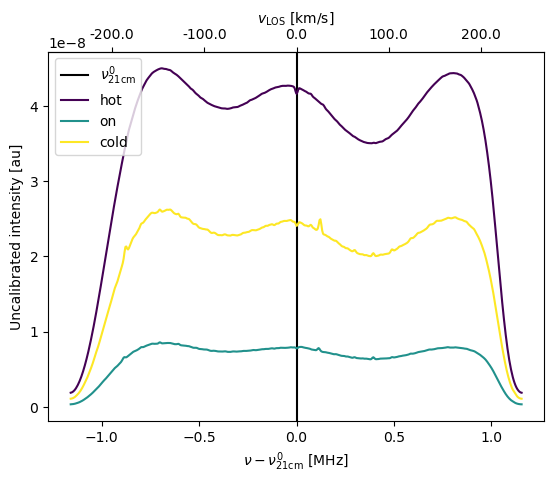

In [12]:
FOn = [fHot, fOn, fCold]
POn = [pHot, pOn, pCold]
Labels= ['hot', 'on', 'cold']

fig, ax, ax2 = d21.plot(FOn, POn, Labels)

Can a multiplicative factor get all the smooth baselines on top of each other?
I am rescaling hot and on to match cold, using the best fit linear amplitude.

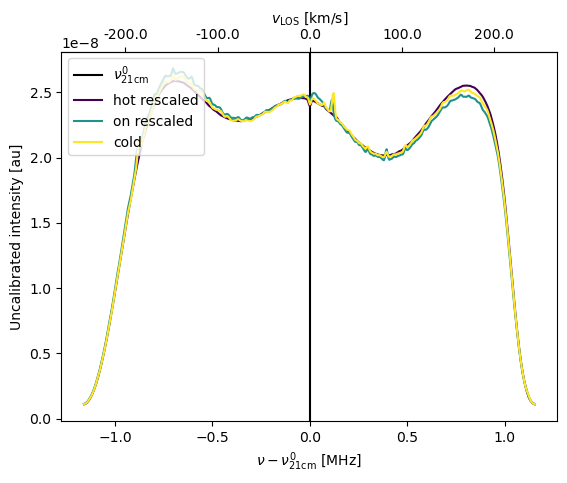

In [13]:
FOn = [fHot, fOn, fCold]
POn = [pHot * np.sum(pHot*pCold) / np.sum(pHot**2), 
       pOn * np.sum(pOn*pCold) / np.sum(pOn**2), 
       pCold]
Labels= ['hot rescaled', 'on rescaled', 'cold']

fig, ax, ax2 = d21.plot(FOn, POn, Labels)

Check how much the ratio varies.
After the rescaling, the ratio between on and cold appears to be a perfectly straight line.
We still have the issue of the RFI line in cold not present in on, but this would not affect the continua.

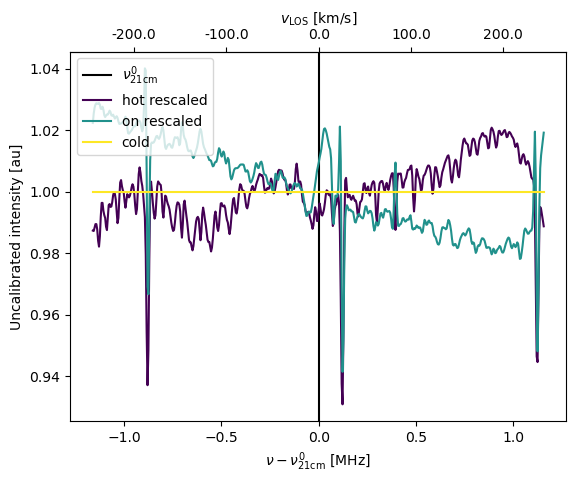

In [14]:
FOn = [fHot, fOn, fCold]
POn = [pHot / pCold * np.sum(pHot*pCold) / np.sum(pHot**2), 
       pOn / pCold * np.sum(pOn*pCold) / np.sum(pOn**2), 
       np.ones_like(pCold)]
Labels= ['hot rescaled', 'on rescaled', 'cold']

fig, ax, ax2 = d21.plot(FOn, POn, Labels)

# Analyzing the sequence of ON exposures

In [15]:
FOn = np.array([expOnFile['fOn'] for expOnFile in expOnFiles])
POn = np.array([expOnFile['pOn'] for expOnFile in expOnFiles])

The sequence of exposures spanned 4h

In [16]:
print(expOnTimeStamps)
# exposure times in minutes from first one

expOnHours = (expOnTimes - expOnTimes[0]) / 3600.
print(expOnHours)

['20250525_02h01m34s' '20250525_2h11m51s' '20250525_2h18m43s'
 '20250525_2h25m36s' '20250525_2h32m29s' '20250525_2h39m23s'
 '20250525_2h46m15s' '20250525_2h53m9s' '20250525_3h0m1s'
 '20250525_3h13m47s' '20250525_3h20m40s' '20250525_3h27m33s'
 '20250525_3h34m26s' '20250525_3h41m20s' '20250525_3h48m13s'
 '20250525_3h55m7s' '20250525_3h6m54s' '20250525_4h15m47s'
 '20250525_4h1m59s' '20250525_4h22m40s' '20250525_4h29m34s'
 '20250525_4h36m26s' '20250525_4h43m20s' '20250525_4h50m13s'
 '20250525_4h57m7s' '20250525_4h8m53s' '20250525_5h10m54s'
 '20250525_5h17m48s' '20250525_5h24m42s' '20250525_5h31m37s'
 '20250525_5h38m29s' '20250525_5h45m23s' '20250525_5h4m1s'
 '20250525_5h52m16s' '20250525_5h59m9s' '20250525_6h12m56s'
 '20250525_6h19m49s' '20250525_6h26m39s' '20250525_6h6m2s']
[0.         0.17138889 0.28583333 0.40055556 0.51527778 0.63027778
 0.74472222 0.85972222 0.97416667 1.20361111 1.31833333 1.43305556
 1.54777778 1.66277778 1.7775     1.8925     1.08888889 2.23694444
 2.00694444 2.351

Re-sort the exposures to be in chronological order

In [17]:
# Get the indices that would sort expOnHours
sort_indices = np.argsort(expOnHours)

# Apply the sorting to all arrays
fOn = fOn[sort_indices]
pOn = pOn[sort_indices]
expOnTimes = expOnTimes[sort_indices]
expOnTimeStamps = expOnTimeStamps[sort_indices]
expOnHours = expOnHours[sort_indices]

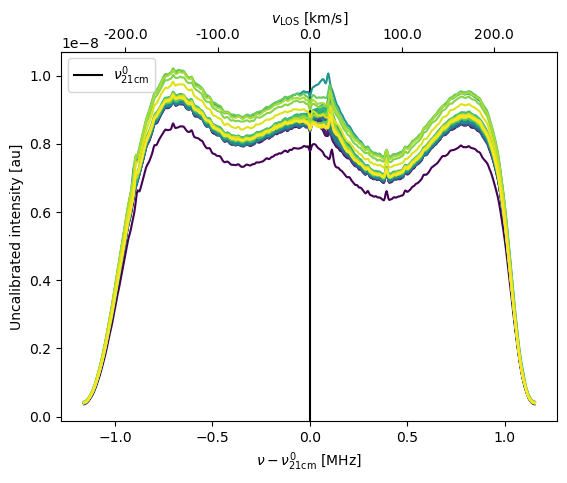

In [18]:
fig, ax, ax2 = d21.plot(FOn, POn)

## Dividing all the on spectra by one of them, it is striking to see that their continua only differ bya multiplicative factor.

The very first on exposure is weird (as we see in the amplitude plot below). For the last few, the sun was probably rising. We start at the next one

In [19]:
iRefExp = -1

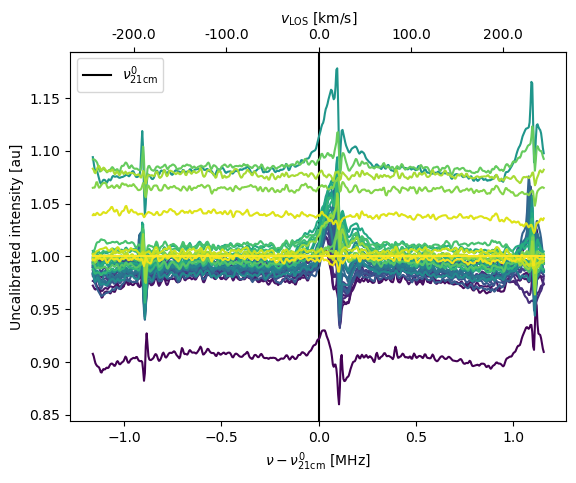

In [20]:
POnOverRef = POn / POn[iRefExp, :]

fig, ax, ax2 = d21.plot(FOn, POnOverRef)

Rescaling for this amplitude, we get a constant continuum to subpercent over many hours!

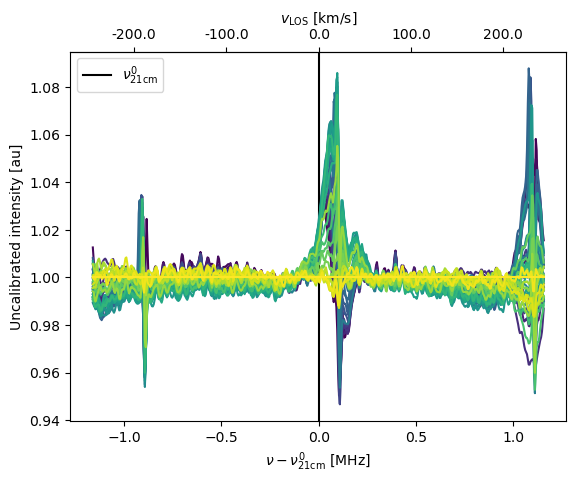

In [21]:
ref = POn[iRefExp, :]  # reference row
dot_products = np.sum(POn * ref, axis=1)         # shape (N,)
row_norms_squared = np.sum(POn**2, axis=1)       # shape (N,)
scaling_factors = dot_products / row_norms_squared  # shape (N,)

POnOverRefRescaled = (POn / ref) * scaling_factors[:, None]

fig, ax, ax2 = d21.plot(FOn, POnOverRefRescaled)

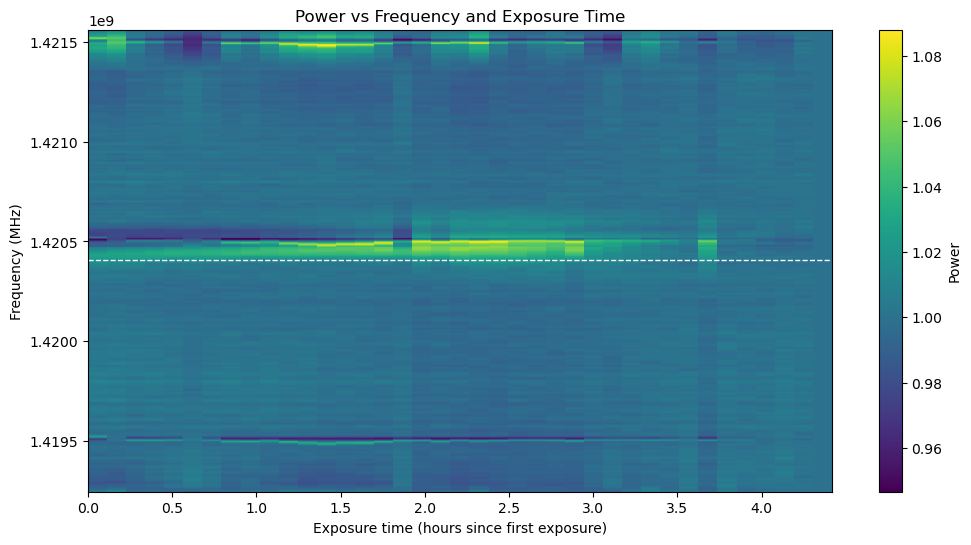

In [22]:
plt.figure(figsize=(12, 6))

# Plot with freq on Y and exposure time on X
plt.imshow(POnOverRefRescaled.T, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest',
           extent=[expOnHours[0], expOnHours[-1], FOn[0][0], FOn[0][-1]])

plt.axhline(d21.nu21cm, color='w', linestyle='--', linewidth=1)

plt.xlabel('Exposure time (hours since first exposure)')
plt.ylabel('Frequency (MHz)')
plt.title('Power vs Frequency and Exposure Time')
plt.colorbar(label='Power')

plt.show()

## See how the multiplicative amplitude evolves over time: a broad trend at the 3% level, and weird spikes of 8% in size.

In [23]:
AmpOverRef = np.sum(POnOverRef, axis=-1) / np.sum(POnOverRef[iRefExp,:])

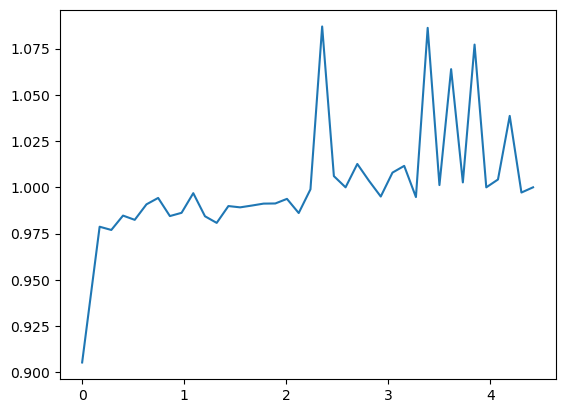

In [24]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.plot(expOnHours, AmpOverRef)

#
plt.show()

## What happens is we select only the exposures where the amplitude does not spike?

In [25]:
thresholdMax = 1.025
thresholdMin = 0.95
indices = np.where((AmpOverRef < thresholdMax) * (AmpOverRef > thresholdMin))[0]
print(indices)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25
 26 27 28 30 32 34 35 37 38]


In [26]:
POnOverRefRescaledMasked = POnOverRefRescaled[indices,:]
FOnMasked = FOn[indices,:]
expOnHoursMasked = expOnHours[indices]
AmpOverRefMasked = AmpOverRef[indices]

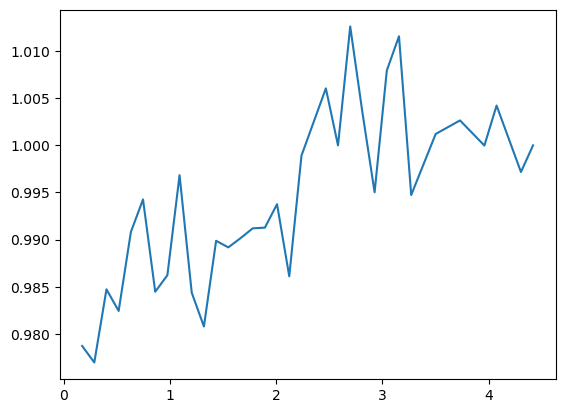

In [27]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.plot(expOnHoursMasked, AmpOverRefMasked)

#
plt.show()

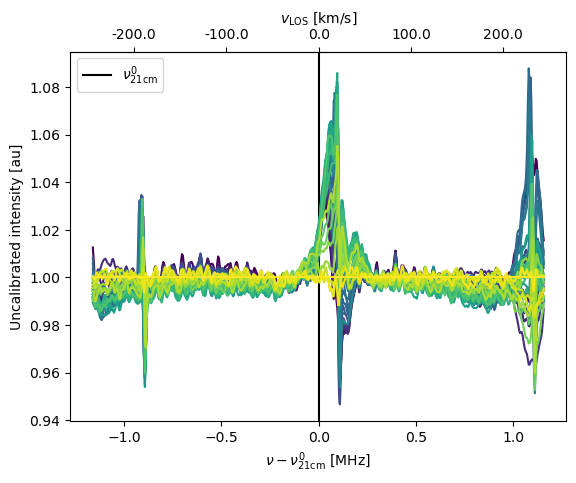

In [28]:
fig, ax, ax2 = d21.plot(FOn[indices,:], POnOverRefRescaled[indices,:])

Without masking

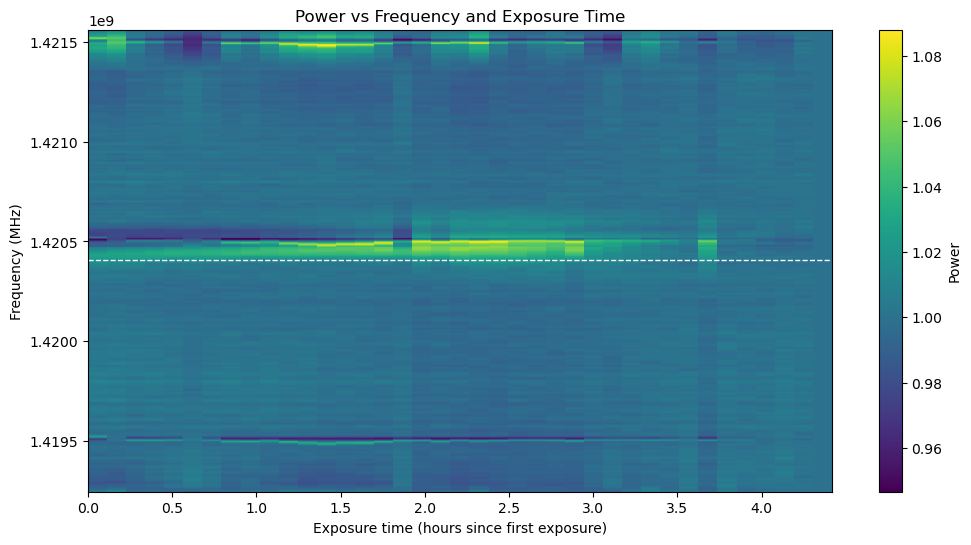

In [29]:
plt.figure(figsize=(12, 6))

# Plot with freq on Y and exposure time on X
plt.imshow(POnOverRefRescaled.T, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest',
           extent=[expOnHours[0], expOnHours[-1], FOn[0][0], FOn[0][-1]])
plt.axhline(d21.nu21cm, color='w', linestyle='--', linewidth=1)

plt.xlabel('Exposure time (hours since first exposure)')
plt.ylabel('Frequency (MHz)')
plt.title('Power vs Frequency and Exposure Time')
plt.colorbar(label='Power')

plt.show()

With masking

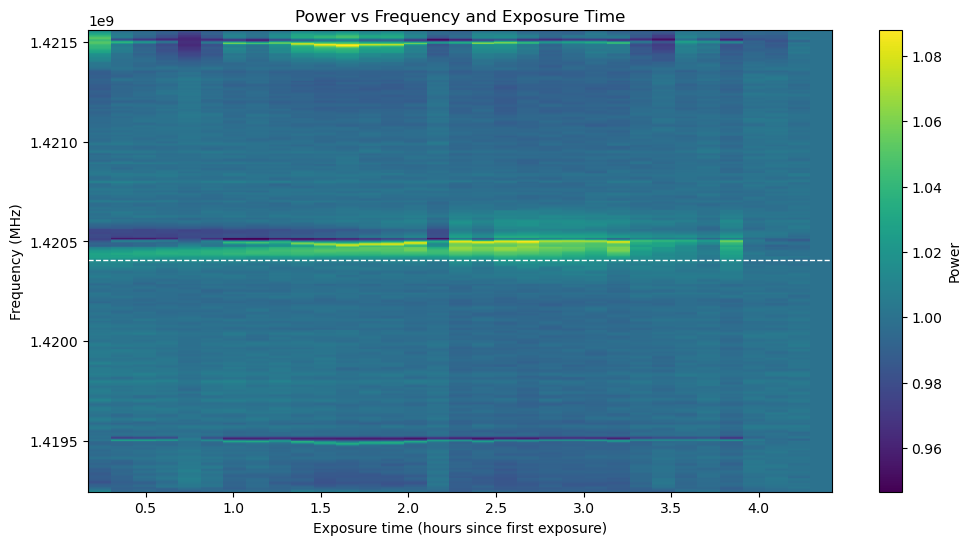

In [30]:
plt.figure(figsize=(12, 6))

# Plot with freq on Y and exposure time on X
plt.imshow(POnOverRefRescaledMasked.T, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest',
           extent=[expOnHoursMasked[0], expOnHoursMasked[-1], FOnMasked[0][0], FOnMasked[0][-1]])
plt.axhline(d21.nu21cm, color='w', linestyle='--', linewidth=1)

plt.xlabel('Exposure time (hours since first exposure)')
plt.ylabel('Frequency (MHz)')
plt.title('Power vs Frequency and Exposure Time')
plt.colorbar(label='Power')

plt.show()

Interestingly, the exposures masked based on the overall amplitude spikes are not the ones that actually look problematic on the 2d plot.

The blue horizontal blurry line suggest that my reference exposure actually had some 21cm in it, such that the next exposures didn't have it. This results in a spurious "negative" 21cm signal.

Generate a gif to see the evolution

In [31]:
# Function to generate individual plots
def generate_plots(FOn, POn, output_dir="temp_plots"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # List to store file names of each generated plot
    plot_files = []
    
    # Loop through the data and create a plot for each element
    for i, (f, p) in enumerate(zip(FOn, POn)):
        fig, ax, ax2 = d21.plot(f, p)
        ax.set_title(f"Plot {i+1}")
        ax.set_ylim(0.94, 1.1)
        
        # Save the plot as an image
        plot_file = os.path.join(output_dir, f"plot_{i+1}.png")
        plt.savefig(plot_file)
        plot_files.append(plot_file)
        plt.close(fig)  # Close the figure to free up memory
    
    return plot_files

# Function to create a GIF from the saved plot images
def create_gif(plot_files, gif_name="output.gif", duration=0.5):
    with imageio.get_writer(gif_name, mode='I', duration=duration) as writer:
        for plot_file in plot_files:
            image = imageio.imread(plot_file)
            writer.append_data(image)
    
    # Optionally: Clean up the temporary images
#    for plot_file in plot_files:
#        os.remove(plot_file)

In [32]:
# Generate plots and create a GIF
plot_files = generate_plots(FOn[indices,:], POnOverRefRescaled[indices,:])
create_gif(plot_files, gif_name="output.gif", duration=0.5)

print("GIF created successfully!")

/tmp/ipykernel_8383/3553694823.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(plot_file)


GIF created successfully!


# Can I use the hot exposure as my baseline? It doesn't have RFI, but at least it has no H1 for sure

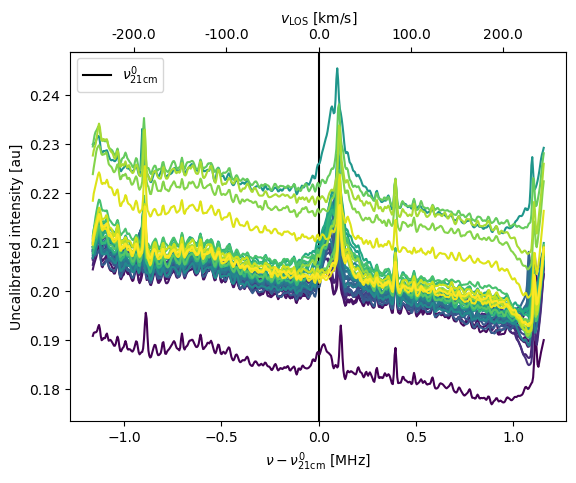

In [33]:
POnOverHot = POn / pHot

fig, ax, ax2 = d21.plot(FOn, POnOverHot)

Mask the frequencies where a baseline subtraction will be tricky

In [35]:
IFreqTrim = np.where(
    (FOn[0, :] > d21.nu21cm - 0.5e6) &(FOn[0, :] < d21.nu21cm + 0.8e6)
)[0]

In [36]:
POnOverHotFmasked = POnOverHot[:,IFreqTrim]
FOnFmasked = FOn[:,IFreqTrim]

In [37]:
def fit_polynomial(x, y, degree):
    """
    Fit a polynomial of given degree to data (x, y).
    
    Parameters:
        x (array-like): 1D array of independent variable values.
        y (array-like): 1D array of dependent variable values.
        degree (int): Degree of the polynomial to fit.
    
    Returns:
        poly (np.poly1d): A polynomial object you can evaluate like a function.
    """
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    return poly



In [62]:
iTest = 10

In [63]:
IFreqFit = np.where(
    (FOnFmasked[iTest, :] < d21.nu21cm - 0.2e6) |
    (FOnFmasked[iTest, :] > d21.nu21cm + 0.3e6)
)[0]

In [64]:
x = FOnFmasked[iTest,IFreqFit]
y = POnOverHotFmasked[iTest,IFreqFit]

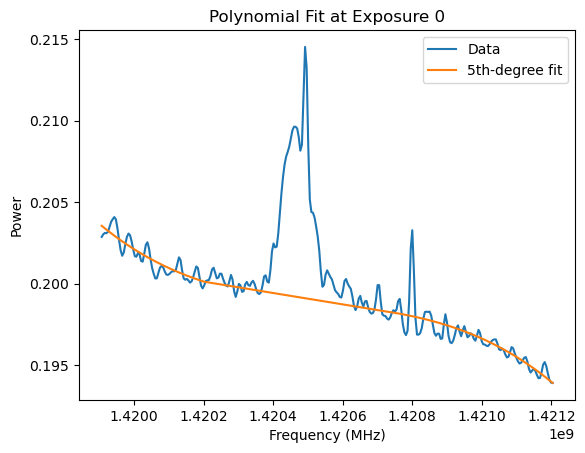

In [66]:
# Fit a degree-5 polynomial
poly = fit_polynomial(x, y, degree=3)

# Evaluate the polynomial
y_fit = poly(x)

# Plot

plt.plot(FOnFmasked[iTest,:], POnOverHotFmasked[iTest,:], label='Data', markersize=3)
plt.plot(x, y_fit, '-', label='5th-degree fit')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power')
plt.title('Polynomial Fit at Exposure 0')
plt.legend()
plt.show()

In [42]:
POnOverHotBasesub = np.zeros_like(POnOverHotFmasked)

for i in range(len(FOnFmasked[:,0])):
    x = FOnFmasked[i,IFreqFit]
    y = POnOverHotFmasked[i,IFreqFit]

    # Fit a degree-5 polynomial
    poly = fit_polynomial(x, y, degree=3)
    
    # Evaluate the polynomial
    y_fit = poly(FOnFmasked[i,:])

    POnOverHotBasesub[i,:] = POnOverHotFmasked[i,:] - y_fit


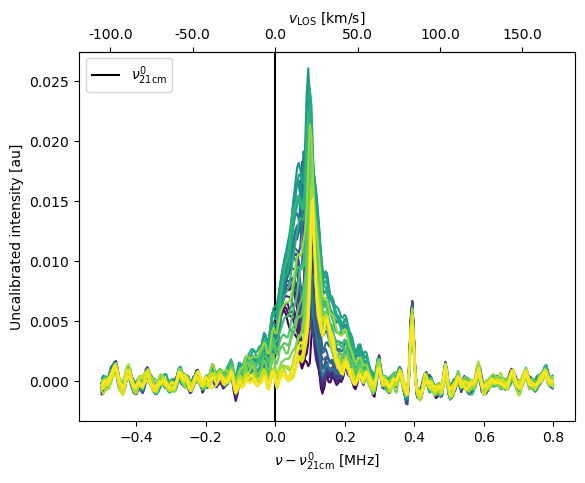

In [43]:
fig, ax, ax2 = d21.plot(FOnFmasked, POnOverHotBasesub)

Try to remove pointlike RFI. Did not do anything:my RFI lines must actually be resolved

In [58]:
def suppress_statistical_spikes_1d(row, sigma_thresh=5.0):
    """
    Suppress spikes in a 1D array based on deviation from neighbors.

    Parameters:
        row (1D array): Input data
        sigma_thresh (float): Threshold in std deviations

    Returns:
        Cleaned 1D array
    """
    row = row.copy()
    deltas = row[1:-1] - 0.5 * (row[0:-2] + row[2:])
    std_jump = np.std(deltas)

    for j in range(1, len(row) - 1):
        delta = row[j] - 0.5 * (row[j - 1] + row[j + 1])
        if np.abs(delta) > sigma_thresh * std_jump:
            row[j] = 0.5 * (row[j - 1] + row[j + 1])
    return row

In [59]:
POnOverHotBasesubRFIsub = np.zeros_like(POnOverHotBasesub)

for i in range(len(FOnFmasked[:,0])):
    POnOverHotBasesubRFIsub[i,:] = suppress_statistical_spikes_1d(POnOverHotBasesub[i,:], sigma_thresh=1.0)

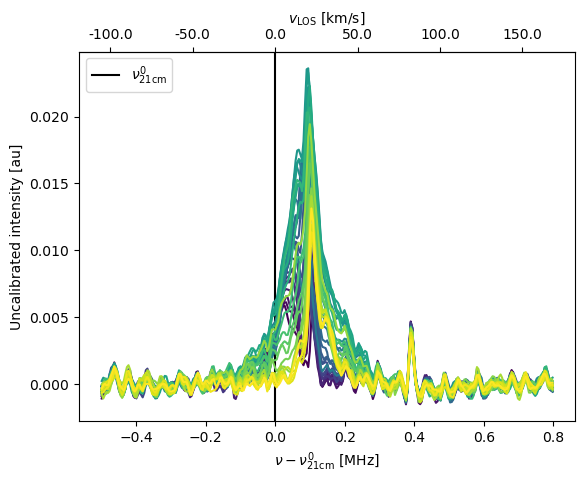

In [60]:
fig, ax, ax2 = d21.plot(FOnFmasked, POnOverHotBasesubRFIsub)

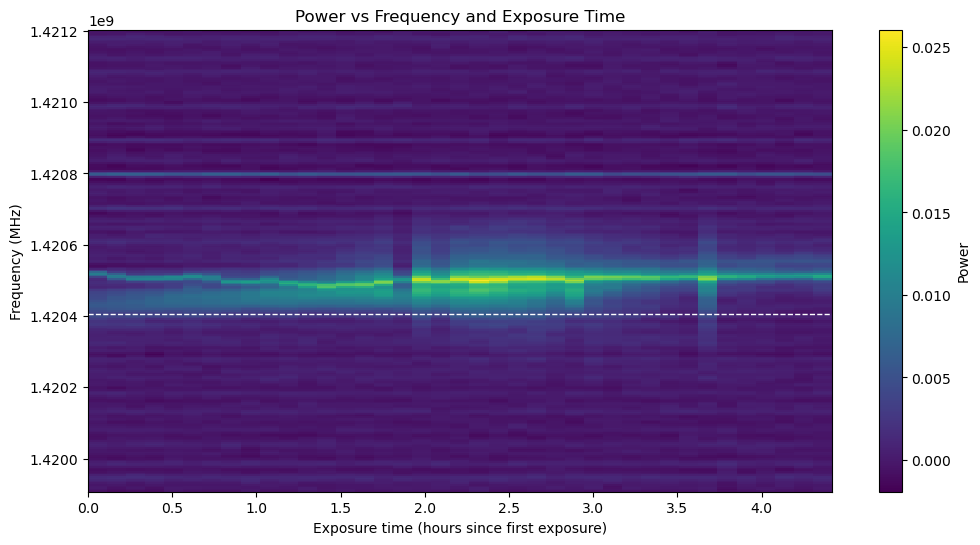

In [44]:
plt.figure(figsize=(12, 6))

# Plot with freq on Y and exposure time on X
plt.imshow(POnOverHotBasesub.T, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest',
           extent=[expOnHours[0], expOnHours[-1], FOnFmasked[0][0], FOnFmasked[0][-1]])
plt.axhline(d21.nu21cm, color='w', linestyle='--', linewidth=1)

plt.xlabel('Exposure time (hours since first exposure)')
plt.ylabel('Frequency (MHz)')
plt.title('Power vs Frequency and Exposure Time')
plt.colorbar(label='Power')

plt.show()

In [46]:
# Function to generate individual plots
def generate_plots(FOn, POn, output_dir="temp_plots"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # List to store file names of each generated plot
    plot_files = []
    
    # Loop through the data and create a plot for each element
    for i, (f, p) in enumerate(zip(FOn, POn)):
        fig, ax, ax2 = d21.plot(f, p)
        ax.set_title(f"Plot {i+1}")
        #ax.set_ylim(0.94, 1.1)
        
        # Save the plot as an image
        plot_file = os.path.join(output_dir, f"plot_{i+1}.png")
        plt.savefig(plot_file)
        plot_files.append(plot_file)
        plt.close(fig)  # Close the figure to free up memory
    
    return plot_files

# Function to create a GIF from the saved plot images
def create_gif(plot_files, gif_name="output.gif", duration=0.5):
    with imageio.get_writer(gif_name, mode='I', duration=duration) as writer:
        for plot_file in plot_files:
            image = imageio.imread(plot_file)
            writer.append_data(image)
    
    # Optionally: Clean up the temporary images
#    for plot_file in plot_files:
#        os.remove(plot_file)

In [47]:
# Generate plots and create a GIF
plot_files = generate_plots(FOnFmasked, POnOverHotBasesub)
create_gif(plot_files, gif_name="output.gif", duration=0.5)

print("GIF created successfully!")

/tmp/ipykernel_8383/959569258.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(plot_file)


GIF created successfully!
